# Exploring the Impact of Activation Functions on Dead Neurons in Annealed BetaVAEs

During my master thesis, I noticed during initial tests that LeakyReLU activations worked a lot better than ReLU on the Annealed BetaVAE, presumably due to dead neurons caused by the initially high regularization. So in this work I test this hypothesis and do some exploration and visualization of the findings.

The Annealed BetaVAE by [[Burgess et al., 2018]](https://arxiv.org/abs/1804.03599) is a common VAE Architecture, which achieves relatively good results while being relatively simple. 

[[Locatello et al., 2019]](https://arxiv.org/abs/1811.12359) did perform an extensive evaluation of VAE Architectures, where the Annealed BetaVAE achieved subpar results. It will be interesting to see if the use of ReLU activation might have a significant effect.


This Report presents the results of several trained VAE models (as specified below). To test the hypothesis the number of updates each weight recives are visualized in order to gain insights into behaviour of the network weights during training, specifically, to what extend dead weights appear.

Source code: https://github.com/sebzap/deadneurons_in_vae

## Evaluation Setup

- Comparison of identical models trained on either the ReLU or the LeakyReLU activation function.
- Logging of the number of updates of each weight
- Same Network Architecture as in [Locatello et al., 2019].
    - A relatively simple Convolutional NN Architecture.
    - 10 dimensional latent space
- All Models are trained and evaluated on the [dSprites dataset](https://github.com/deepmind/dsprites-dataset)
<br>
<img src="https://github.com/deepmind/dsprites-dataset/blob/master/dsprites.gif?raw=true" />
- Trained reproducibly. Random seeds: 9863185, 1506004, 5863596, 9621873, 3972279, 7694365
- Models are trained for 50 epochs on a batch size of 256 (108000 Updates)
- Annealed BetaVAE configuration
    - $\gamma = 100$
    - max capacity: 50
    - capacity increases over 72000 iterations (~33 epochs)



In [1]:
# Loading the training data
from project_report_nb import loadTensorboard 

path = './project_report_nb_data/runs'
df = loadTensorboard(path)

c:\Users\szapl\miniconda3\envs\carla_disentanglement\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Reconstruction Quality

This first section will provide an overview of the reconstruction quality achieved by the models trained and compare the two different activation functions. This is one of the two performance criterions that one might care about. (The other, disentanglment quality, will be presented in the next section.)

Quantitatively: The models using LeakyReLU show lower reconstruction error for all random seeds (after 50 epochs).


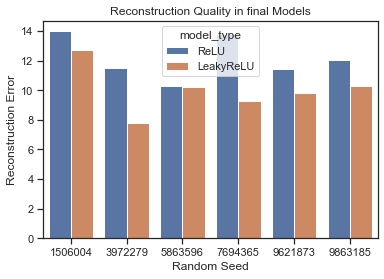

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='ticks')

data = df[df['step'] ==49]
metrics = ["MSE reconstruction/eval"]
data = data[data['metric'].isin(metrics)]
ax = sns.barplot(data=data, y='value', x="seed", hue="model_type")
ax.set_ylabel("Reconstruction Error")
ax.set_xlabel("Random Seed")
ax.set_title("Reconstruction Quality in final Models")

plt.show()

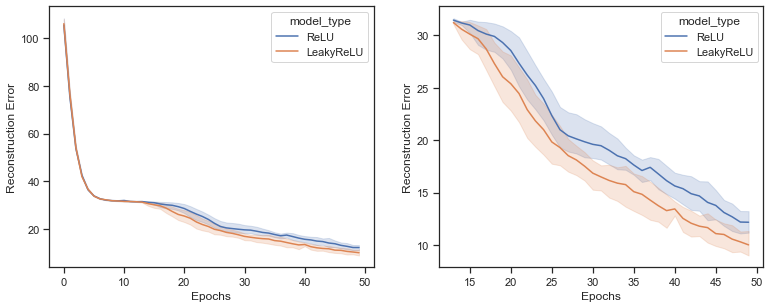

In [3]:
data = df
fig, axs = plt.subplots(ncols=2, nrows=1, figsize= [6.4*2, 4.8*1])
metrics = ["MSE reconstruction/eval"]
data = data[data['metric'].isin(metrics)]
ax = sns.lineplot(data=data, y='value', x="step", hue="model_type", ax=axs[0])
ax.set_ylabel("Reconstruction Error")
ax.set_xlabel("Epochs")
ax = sns.lineplot(data=data[data.step > 12], y='value', x="step", hue="model_type", ax=axs[1])
ax.set_ylabel("Reconstruction Error")
ax.set_xlabel("Epochs")

plt.show()

When looking at the training behaviour, we can see that there is initially little difference in reconstruction error, and only after some time the models diverge, with the LeakyReLU models being always just below the ReLU models. No significant divergence is happening.

LeakyReLU does achieve statistically significant better reconstruction (with alpha value of 5%).

In [4]:
from scipy.stats import mannwhitneyu
data = df[df['step'] ==49]
metrics = ["MSE reconstruction/eval"]
data = data[data['metric'].isin(metrics)]
mannwhitneyu(data[data['model_type'] == 'LeakyReLU']['value'].values, data[data['model_type'] == 'ReLU']['value'].values, alternative='less')

MannwhitneyuResult(statistic=5.0, pvalue=0.02266378103898607)

Qualitatively: As a representative example, the images below present reconstructions from the models trained on random seed 1506004 on hand selected inputs (different spapes and postions). 

Both models have problems reconstructing sharp corners, so squares are reconstructed with rounded corners, small squares are basically circles. Also both models have problems reconstructing hearts, however the model with the LeakyRelu seems to be able create freer shapes, while the ReLU model reconstructions are more deformed circles.

Reconstruction by ReLU Model (Top row: original, bottom row: reconstruction)

![Reconstruction by ReLU Model](project_report_nb_data\imgs\1506004_recon_relu.png "Reconstruction by ReLU Model")

Reconstruction by LeakyReLU Model

![Reconstruction by ReLU Model](project_report_nb_data\imgs\1506004_recon_leaky.png "Reconstruction by ReLU Model")


# 2. Comparison of Disentanglement Quality

Another important aspect of VAE performance is the disentanglement quality, i.e. how useful are the features represented in the latent variables. In some applications this is more important than reconstruction quality. 

Quantitatively: Using four different metrics to measure disentanglement quality in VAEs, there does not seem to be a difference in disentanglement quality.

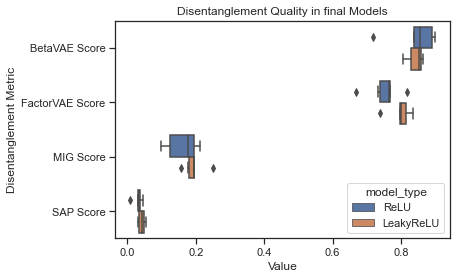

In [5]:
data = df[df['step'] ==49]
metrics = ["beta_vae_score/eval_accuracy", "factor_vae_score/eval_accuracy", "mig_score/discrete_mig", "sap_score/SAP_score"]
data = data[data['metric'].isin(metrics)]
ax = sns.boxplot(data=data, y='metric', x="value", hue="model_type")
ax.set_yticklabels(['BetaVAE Score', 'FactorVAE Score', 'MIG Score', 'SAP Score'])
ax.set_ylabel("Disentanglement Metric")
ax.set_xlabel("Value")
ax.set_title("Disentanglement Quality in final Models")
plt.show()

The test for statistical significance provides a wide range of values, with only one being significance. Overall, LeakyReLU does not provide a significant performance increase. However, the Leaky models do at least show less variance in the disentanglement quality results (as can be seen in the boxplot).

In [6]:
metrics = ["beta_vae_score/eval_accuracy", "factor_vae_score/eval_accuracy", "mig_score/discrete_mig", "sap_score/SAP_score"]
print("  metric \t\t   p-value")
for metric in metrics:
    d = data[data['metric'] == metric]
    test = mannwhitneyu(d[d['model_type'] == 'LeakyReLU']['value'].values, d[d['model_type'] == 'ReLU']['value'].values, alternative='greater')
    print(metric.split('/')[0],"\t\t", test.pvalue)

  metric 		   p-value
beta_vae_score 		 0.7644150007549722
factor_vae_score 		 0.046347901278906284
mig_score 		 0.23558499924502785
sap_score 		 0.08598934096227906


Qualitatively it's hard to see a difference. Both models seem to disentangle y-position well, and the size of the object reasonably. The other factors appear not to be encoded well.

Latent traversal with ReLU Model (Rows: dimensions, Columns: variation)

![](project_report_nb_data\imgs\1506004_lat_relu.png )

Latent traversal with LeakyReLU Model

![](project_report_nb_data\imgs\1506004_lat_leaky.png)


# 3. Dead Neurons

The previous sections showed that the choice of a leaky activation function impacts VAE performance (although mainly reconstruction quality). This section now presents the findings that the ReLU activation function indeed leads to dead neurons, i.e. some weights get zero updates.

 When looking at the first layer, we see that there are about one fithth of neurons dead during training when using the ReLU activation, while LeakyReLU yields zero Dead Neurons.

Then, the second chart gives an overview about all network layers.

The variance in both charts represents the different random seeds, i.e. the effect of the random initialisations of the network weights.

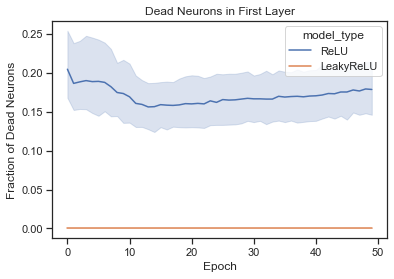

In [7]:
data = df

metrics = ["Dead_Neurons/weight.0.encoder.main.0.weight [32, 1, 4, 4]"]
data = data[data['metric'].isin(metrics)]
ax = sns.lineplot(data=data, y='value', x="step", hue="model_type")
ax.set_xlabel('Epoch')
ax.set_ylabel('Fraction of Dead Neurons')
ax.set_title('Dead Neurons in First Layer')
plt.show()

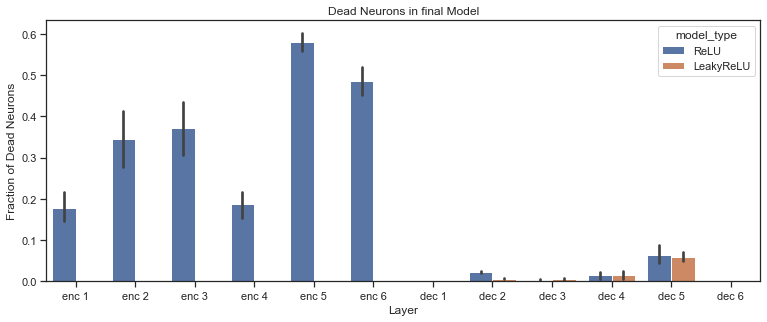

In [8]:
data = df[df['step'] ==49]
data = data[data['metric'].str.startswith("Dead_Neurons/")]
fig, axs = plt.subplots(ncols=1, nrows=1, figsize= [6.4*2, 4.8*1])
ax = sns.barplot(data=data, y='value', x="metric", hue="model_type")
ax.set_xticklabels(list(map(lambda x: 'enc '+str(x+1), range(6)))+list(map(lambda x: 'dec '+str(x+1), range(6))))
ax.set_xlabel('Layer')
ax.set_ylabel('Fraction of Dead Neurons')
ax.set_title('Dead Neurons in final Model')
plt.show()

For the encoder part of the network, ReLU shows high portions of Dead Neurons, while LeakyReLU has 0. In the decoder part, however, both activation functions show small fractions of Dead Neurons. Since most of the dead neuron effect is on the encoder part of the VAE model, most of the following analysis focuses on that.

The VAE loss function applies the KL penalty in the latent layer (after encoder part), which means this part of the loss is only applied to the encoder. (While the reconstruction loss is applied to the whole network). This might play a major role here.
Because the KL Penalty is especially restrictive in the earlier training epochs in the Annealed BetaVAE architecture, it might be that the initial high penalty creates dead Neurons, which cannot be recovered when using the ReLU activation. This Hypothesis will be discussed further in the Section "Annealed-BetaVAE vs BetaVAE".

For the decoder both activations have a small number of Dead Neurons. While we do not investigate this further, a reason for dead neurons in the decoder could be that the upscaling process produces unuseful or redundant features that do not provide any additional information for reconstruction.


# 4. Dead Neuron Visualization

To gain more insight into how the network weights behave when using ReLU, this section will present visualizations of the dead neurons of one representative ReLU model.

In [9]:
from project_report_nb import DeadNeuronViz
from IPython.display import display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")
# sns.reset_orig()

# chart styling
square_heatmap=False
colors = "dark:coral"
titles = ["# of Updates", "Iteration of Last Update", "# of Dead Epochs"]
tick_offset = 2
step_modifier_dict = {
            1: 1,
            4: 1,
            32: 2,
            64: 4
        }

dnviz = DeadNeuronViz(square_heatmap, colors, titles, tick_offset, step_modifier_dict)
dndata = dnviz.load('./project_report_nb_data/dndata', 's1506004_ReLU')

## 4.1. Visualization of Network Weights

First, how to visualize dead neurons? One way is to plot the network weights as an image. This is easy for linear layers, as the weight matrix is 2D tensor for linear layers. So, if we plot the weight matrix as a 2d image, where we choose the color of each pixel based on the number of updates each weight received, this visualizes the dead neurons of a single layer quite nicely. Here is an example of layer 5:


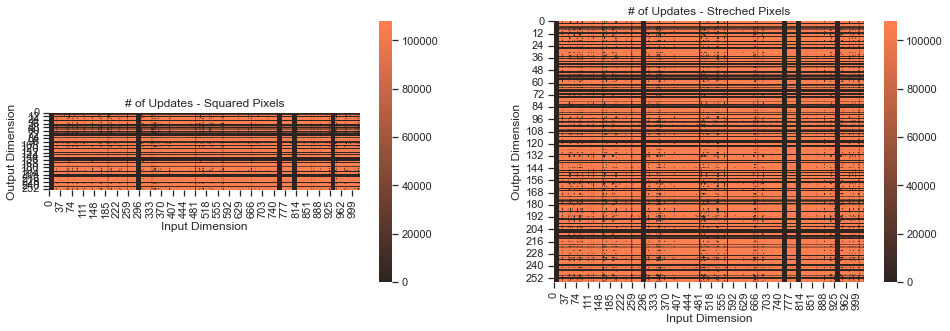

In [10]:
d = dndata[4][0].cpu().numpy()
fig, axs = plt.subplots(ncols=2, nrows=1, figsize= [6.4*2.5, 4.8*1])
fig.subplots_adjust(wspace=0.3)
ax = sns.heatmap(d,cmap=sns.color_palette(dnviz.colors, as_cmap=True), ax=axs[0], vmin=0, vmax=dnviz.total_iterations, square=True)
ax.set(title=dnviz.titles[0]+ " - Squared Pixels")
ax.set(xlabel="Input Dimension", ylabel="Output Dimension")
ax = sns.heatmap(d,cmap=sns.color_palette(dnviz.colors, as_cmap=True), ax=axs[1], vmin=0, vmax=dnviz.total_iterations, square=False)
ax.set(title=dnviz.titles[0]+ " - Streched Pixels")
ax.set(xlabel="Input Dimension", ylabel="Output Dimension")
plt.show()

As we can see in the plot above, sometimes there is a significant difference in the dimensionality of output and input of a layer. This can create long images (either horizontally or vertically) like in the left plot. Alternatively, one can stretch the image to be better "viewable". However, this way it's important to look at the axis to see the dimensionality of output/input, as now individual weights are now rectangle shapes inside the image instead of squares.

Doing the same thing for convolutional layers is a bit tricker as layer weights are a 4D Tensor: output_channels x input_channels x kernel_d1 x kernel_d2. To visualize the kernel weights, I render each kernel like above, and concatenate all 4x4 images into a big image. The input_channels dimension is concatenated on the x-axis, and the output_channels dimension is concatenated on the y-axis. Example of layer 3 (with and without gridlines to distinguish individual kernels):

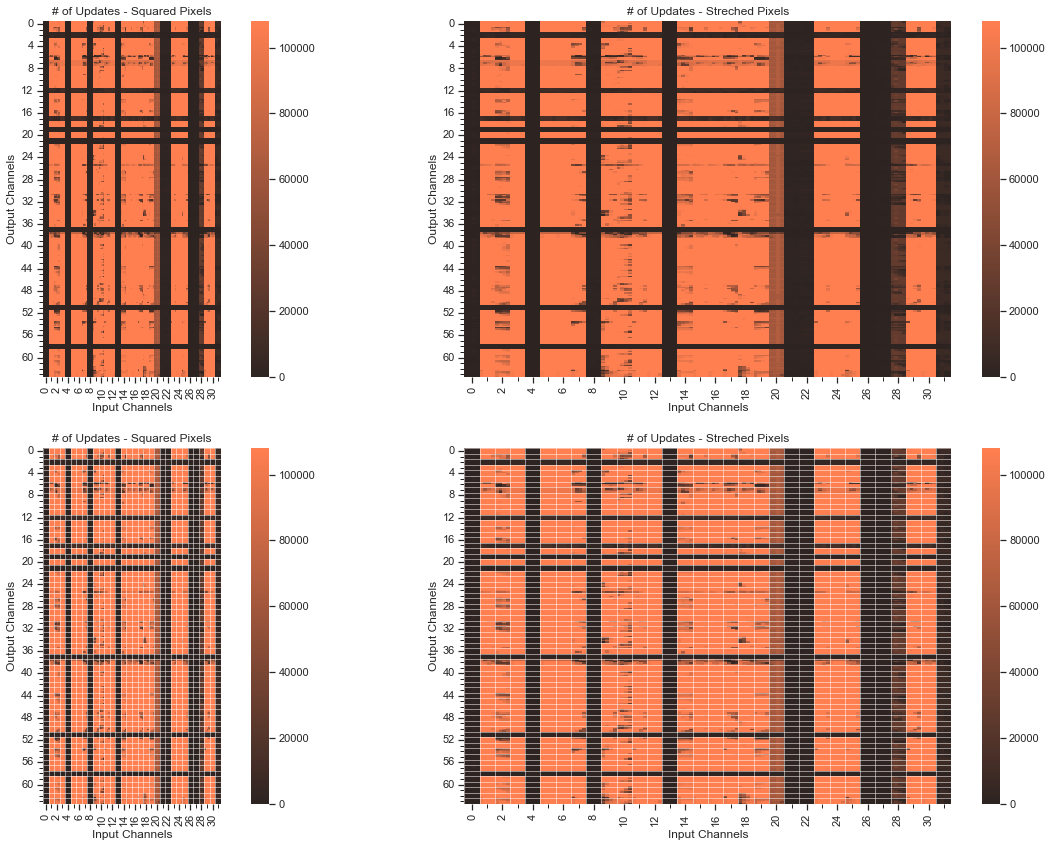

In [11]:
import numpy as np
d = dndata[2][0].cpu().numpy()
d = np.concatenate(d,axis=1)
d = np.concatenate(d,axis=1)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize= np.array([6.4*2.5, 4.8*2])*1.5)
# fig.subplots_adjust(wspace=0.2, hspace=0.2)
ax = sns.heatmap(d,cmap=sns.color_palette(dnviz.colors, as_cmap=True), ax=axs[0,0], vmin=0, vmax=dnviz.total_iterations, square=True)
ax.set(title=dnviz.titles[0]+ " - Squared Pixels")
ax.set(xlabel="Input Channels", ylabel="Output Channels")
dnviz.setConvHeatmapTicks(ax, d.shape)
ax = sns.heatmap(d,cmap=sns.color_palette(dnviz.colors, as_cmap=True), ax=axs[0,1], vmin=0, vmax=dnviz.total_iterations, square=False)
ax.set(title=dnviz.titles[0]+ " - Streched Pixels")
ax.set(xlabel="Input Channels", ylabel="Output Channels")
dnviz.setConvHeatmapTicks(ax, d.shape)

ax = sns.heatmap(d,cmap=sns.color_palette(dnviz.colors, as_cmap=True), ax=axs[1,0], vmin=0, vmax=dnviz.total_iterations, square=True)
ax.set(title=dnviz.titles[0]+ " - Squared Pixels")
ax.set(xlabel="Input Channels", ylabel="Output Channels")
ax.vlines(x = range(0,d.shape[1],4), ymin = 0, ymax = d.shape[0]*4, colors = 'white', lw = .5)
ax.hlines(y = range(0,d.shape[0],4), xmin = 0, xmax = d.shape[1]*4, colors = 'white', lw = .5)
dnviz.setConvHeatmapTicks(ax, d.shape)

ax = sns.heatmap(d,cmap=sns.color_palette(dnviz.colors, as_cmap=True), ax=axs[1,1], vmin=0, vmax=dnviz.total_iterations, square=False)
ax.set(title=dnviz.titles[0]+ " - Streched Pixels")
ax.set(xlabel="Input Channels", ylabel="Output Channels")
dnviz.setConvHeatmapTicks(ax, d.shape)
ax.vlines(x = range(0,d.shape[1],4), ymin = 0, ymax = d.shape[0]*4, colors = 'white', lw = .5)
ax.hlines(y = range(0,d.shape[0],4), xmin = 0, xmax = d.shape[1]*4, colors = 'white', lw = .5)

plt.show()

## 4.2. Dead Neuron Visualization for a Whole Network

Now, this section visualizes all layers of one ReLU model (seed 1506004) to provide better insights into the Dead Neurons. The other models provide a similar picture, so this is a typical representation for all models. In regard to the LeakyReLU models, this kind of visualization is not very interesting for those models as there are very few dead neurons (and zero for the encoder which is the focus of this report).

First, this section provides an extensive visualization of all layers of the model and the following subsections will highlight and provide a deep dive on interesting aspects.

For each layer the following six charts are provided:
* **# of Updates** - Weight  matrix visualization, where the color indicates how many updates (how many batches) updated the respective weight.
* **Iteration of Last Update** - Weight matrix visualization, where the color indicates the index of the last iteration where an update was performed (index 0 if not update at all happened). Shows how early the respective weights died.
* **# of Dead Epochs** - Weight matrix visualization, where the color indicates for how many epochs the respective  weights were dead (i.e. no update in all batches of one epoch). Contrasting this to "# of Updates" it shows if weights are dead all the time or if the odd update goes through sometimes.
* **Dead Neurons** - Shows how the fraction of dead neurons changed over the training process.
* **Weights by Number of Updates** - Histogram that bins the network weights based on the number of updates they recieved.
* **Weights by Training Behaviour** - Groups the weights, based on how they behaved during training, e.g. were dead the whole time, or revived later, etc.

***
### Layer 1:
Convolutional Layer
<br>Shape: torch.Size([32, 1, 4, 4])
<br>12.50% dead weights at the end of training
<br>

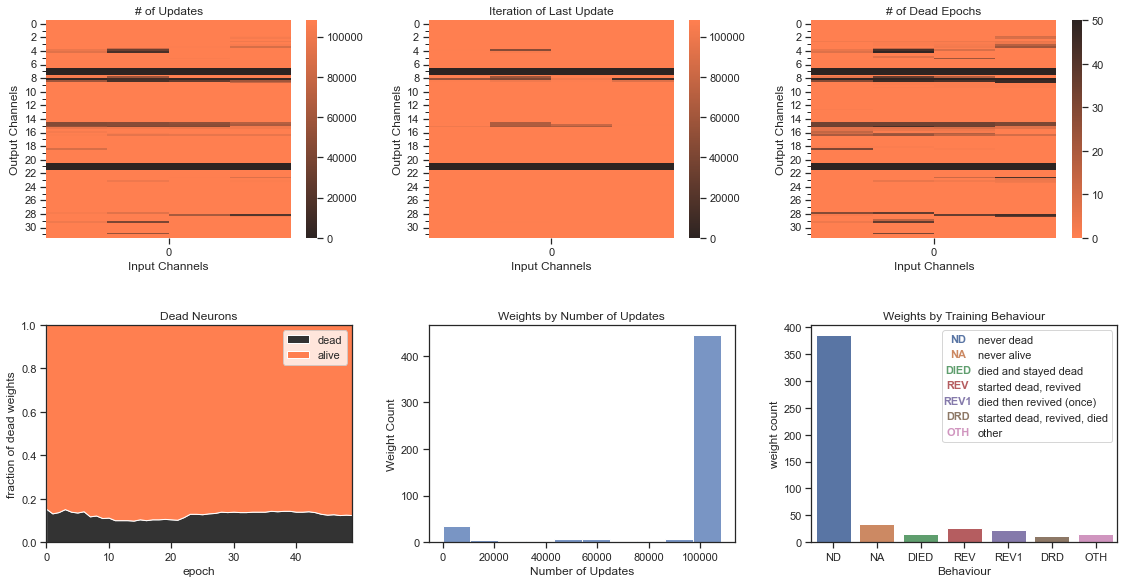

***
### Layer 2:
Convolutional Layer
<br>Shape: torch.Size([32, 32, 4, 4])
<br>41.88% dead weights at the end of training
<br>

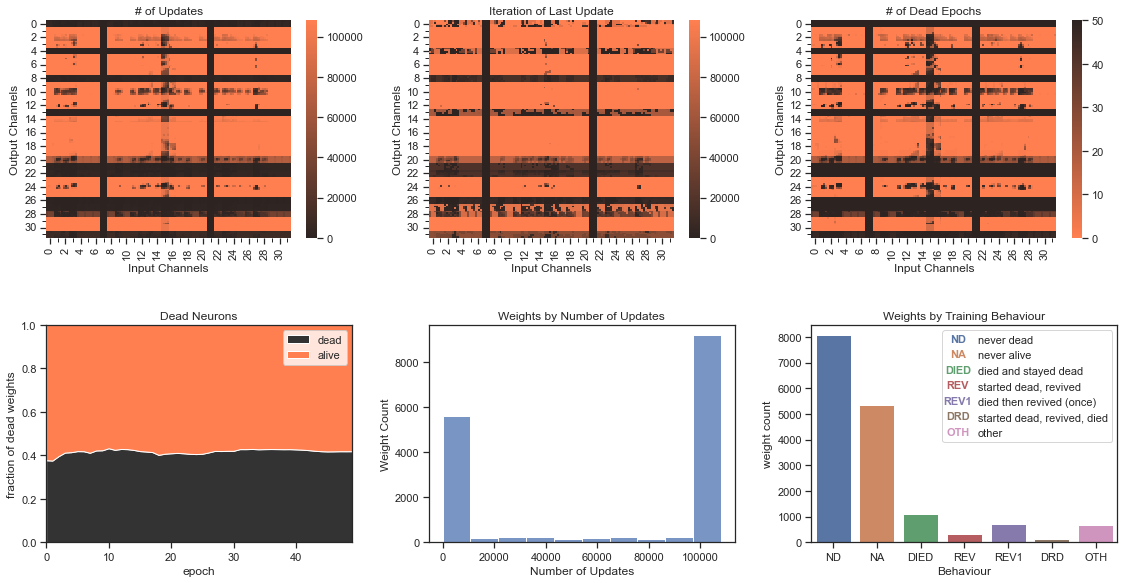

***
### Layer 3:
Convolutional Layer
<br>Shape: torch.Size([64, 32, 4, 4])
<br>46.69% dead weights at the end of training
<br>

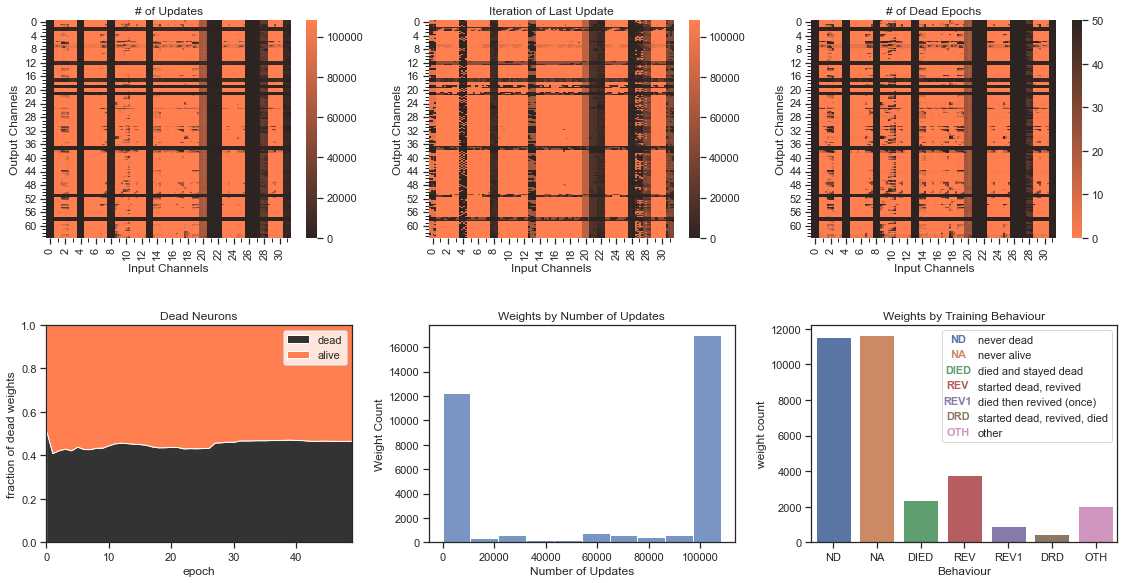

***
### Layer 4:
Convolutional Layer
<br>Shape: torch.Size([64, 64, 4, 4])
<br>22.28% dead weights at the end of training
<br>

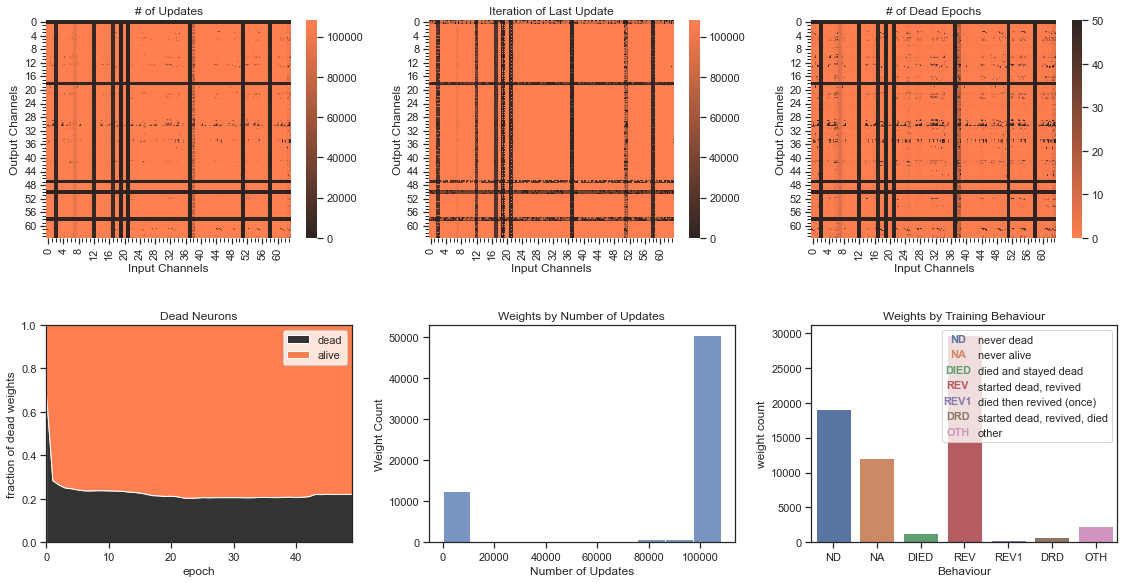

***
### Layer 5:
Linear Layer
<br>Shape: torch.Size([256, 1024])
<br>55.57% dead weights at the end of training
<br>

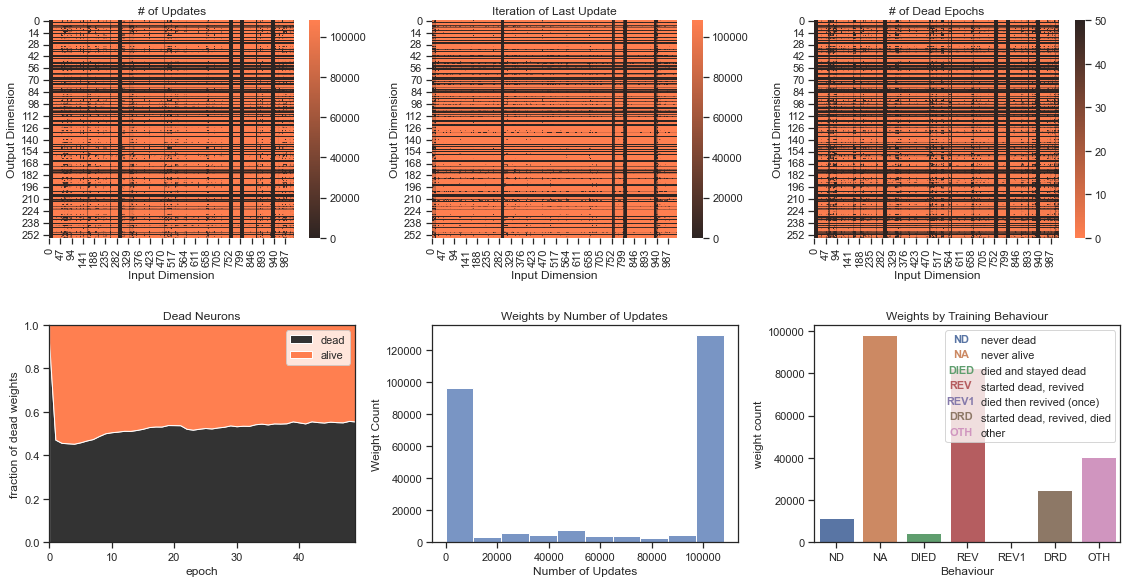

***
### Layer 6:
Linear Layer
<br>Shape: torch.Size([20, 256])
<br>44.92% dead weights at the end of training
<br>

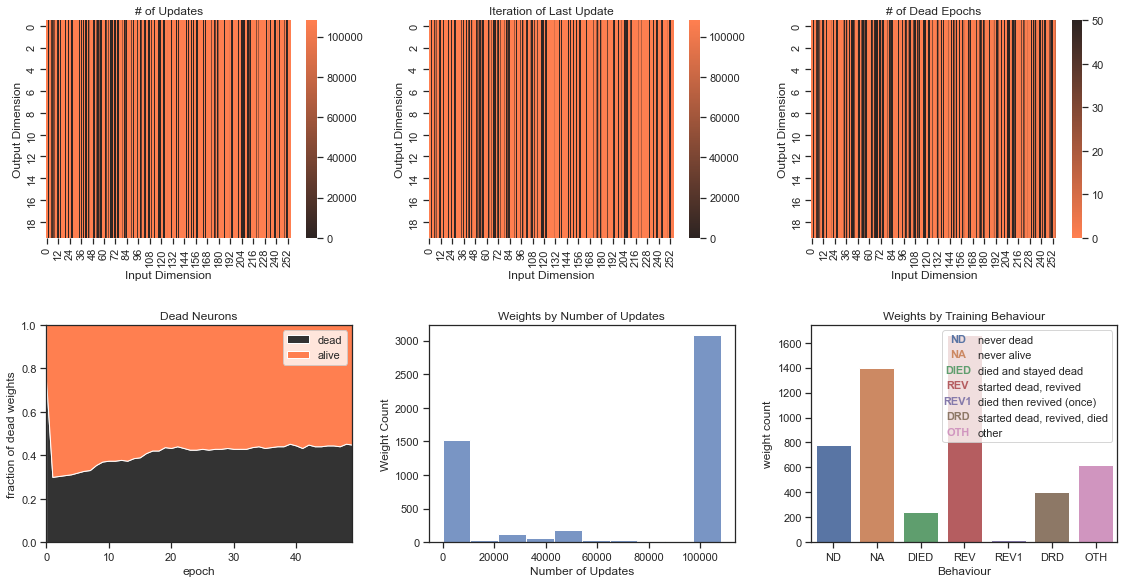

***
### Layer 7:
Linear Layer
<br>Shape: torch.Size([256, 10])
<br>0.00% dead weights at the end of training
<br>

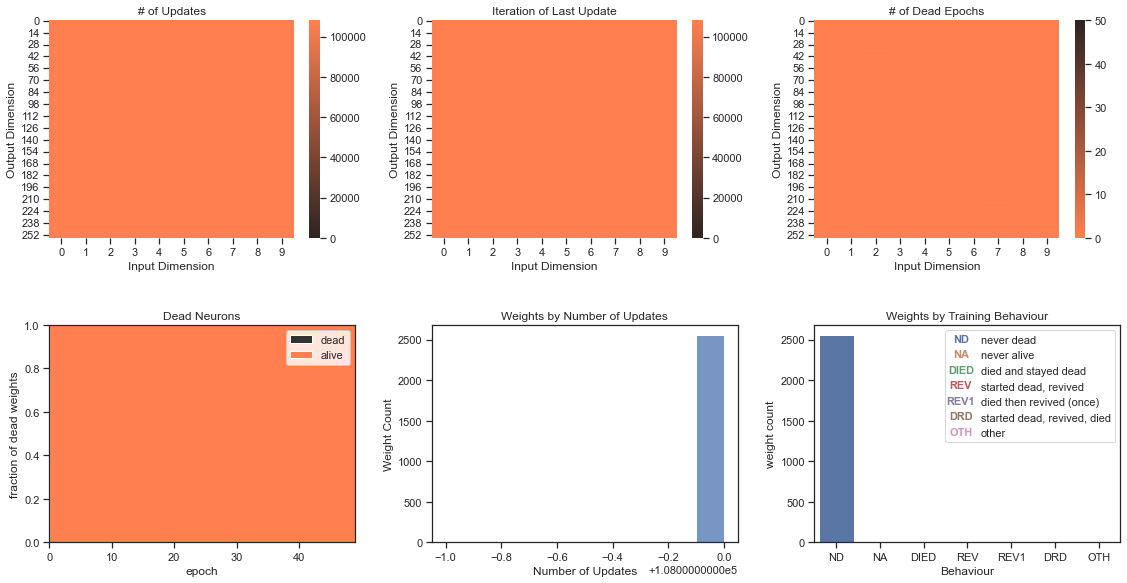

***
### Layer 8:
Linear Layer
<br>Shape: torch.Size([1024, 256])
<br>2.76% dead weights at the end of training
<br>

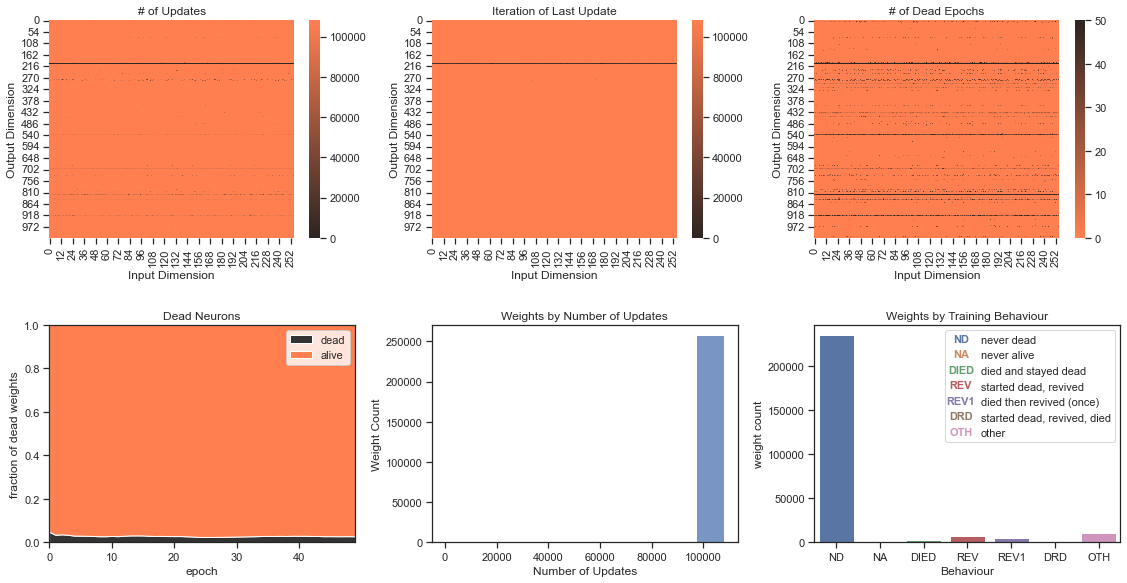

***
### Layer 9:
Transposed Convolutional Layer
<br>Shape: torch.Size([64, 64, 4, 4])
<br>0.53% dead weights at the end of training
<br>

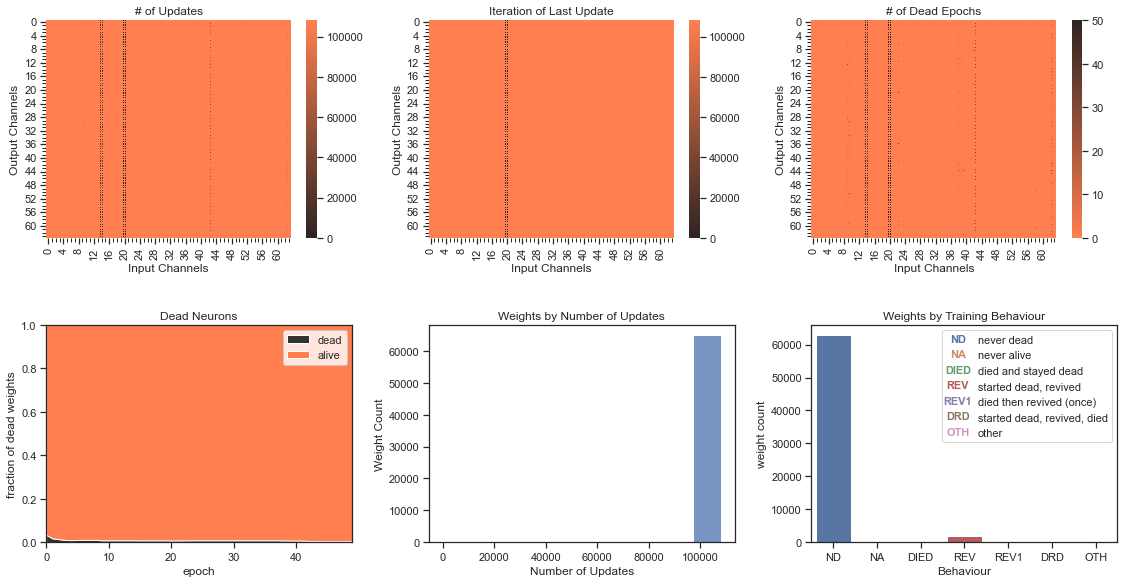

***
### Layer 10:
Transposed Convolutional Layer
<br>Shape: torch.Size([64, 32, 4, 4])
<br>2.40% dead weights at the end of training
<br>

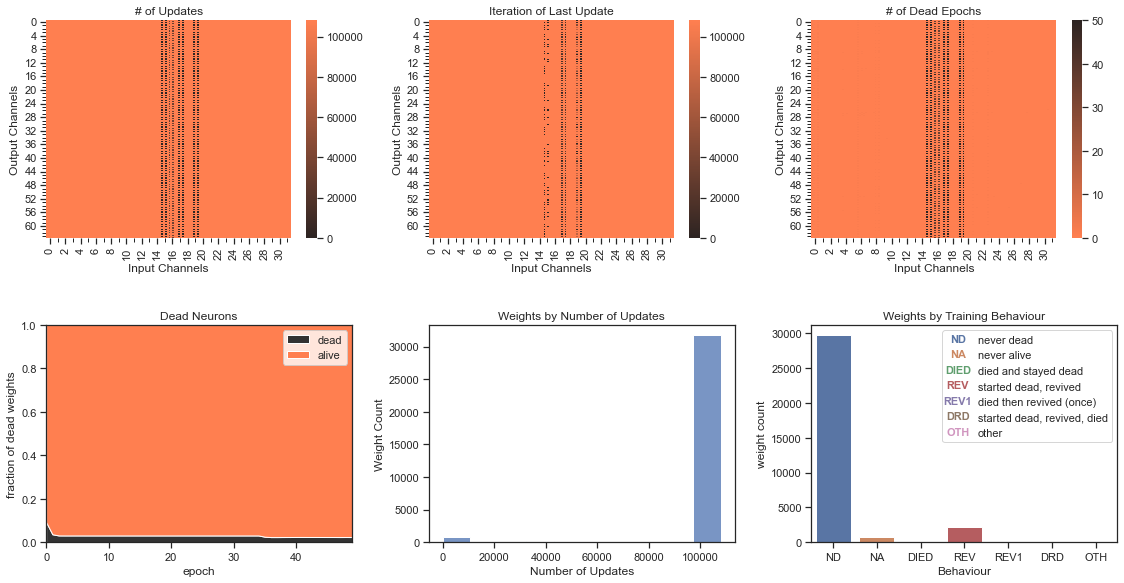

***
### Layer 11:
Transposed Convolutional Layer
<br>Shape: torch.Size([32, 32, 4, 4])
<br>4.69% dead weights at the end of training
<br>

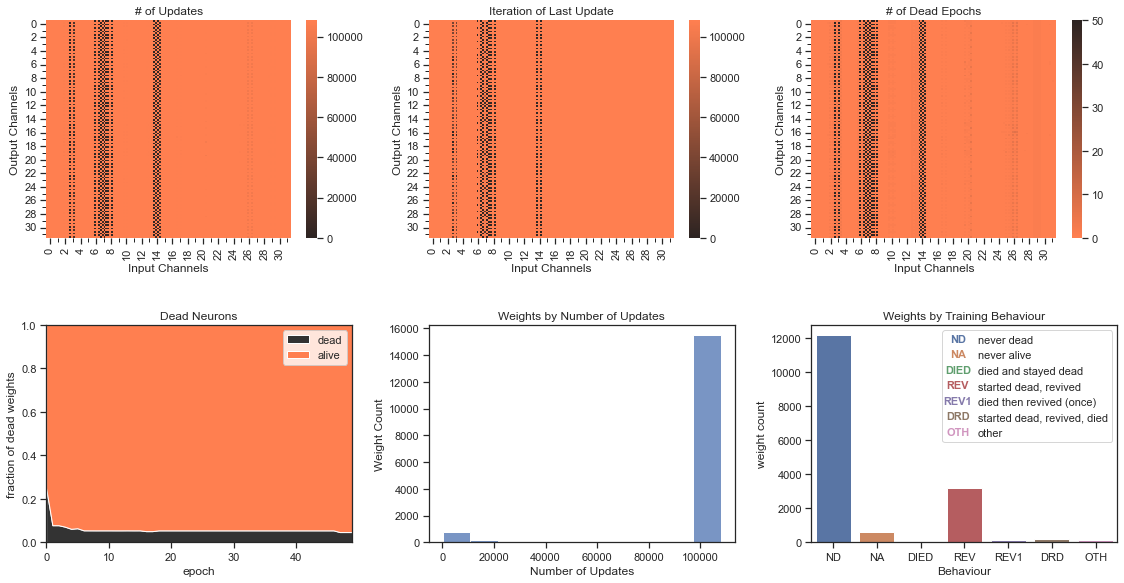

***
### Layer 12:
Transposed Convolutional Layer
<br>Shape: torch.Size([32, 1, 4, 4])
<br>0.00% dead weights at the end of training
<br>

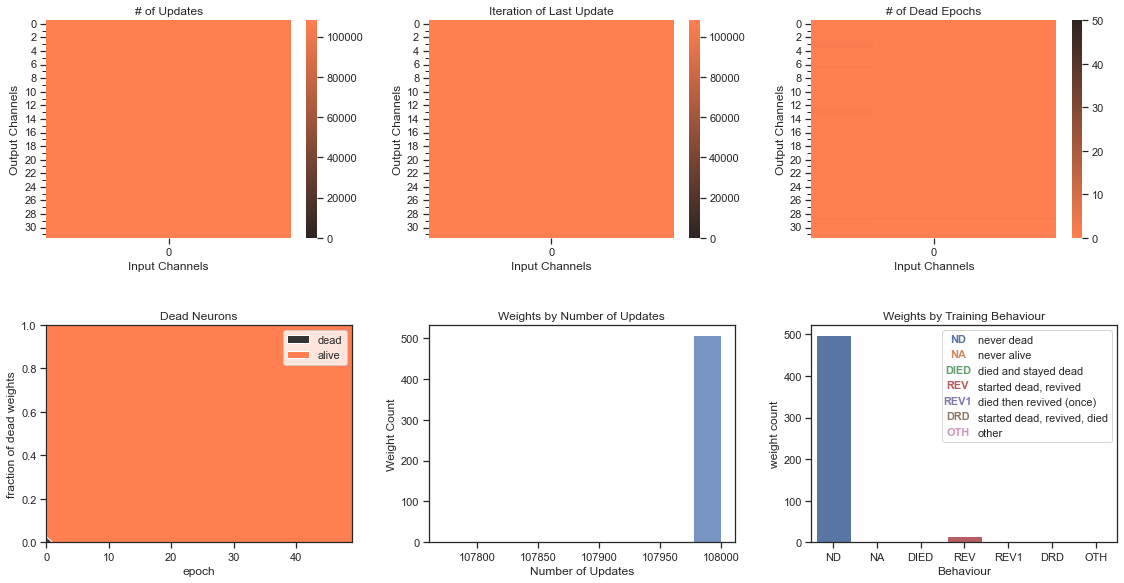

In [12]:
weightTypeDfs = []
for i, weight in enumerate(dnviz.weights):
    text = "***"
    text += "\n### Layer "+str(i+1)+":\n"
    isConv = len(dndata[i][0].shape)==4
    if isConv:
        if (i>6):
            text += "Transposed Convolutional Layer\n<br>"
        else:
            text += "Convolutional Layer\n<br>"
    else:
        text += "Linear Layer\n<br>"

    text += "Shape: "+ str(dndata[i][0].shape) + "\n<br>"

    dn = (dndata[i][2][-1]*1.0).mean()
    text += "{:0.2f}% dead weights at the end of training\n<br>".format(dn*100)
    display(Markdown(text))

    fig, axs = plt.subplots(ncols=3, nrows=2, figsize= [6.4*3, 4.8*2])
    fig.subplots_adjust(
        hspace=0.4,
        wspace=0.25
    )
    
    dnviz.renderHeatmaps(dndata[i],axs[0],isConv=isConv)

    dead_percentages = (dndata[i][2]*1.0).numpy().reshape((50,-1)).mean(-1)
    axs[1,0].stackplot(range(50), dead_percentages, 1-dead_percentages, colors=[(.2,.2,.2), "coral"])
    axs[1,0].set(ylim=(0.,1.), title="Dead Neurons", xlabel="epoch", ylabel="fraction of dead weights")
    axs[1,0].legend(["dead", "alive"])
    axs[1,0].margins(0)

    update_count = dndata[i][0].flatten()
    sns.histplot(update_count, ax=axs[1,1], bins=10)
    axs[1,1].set(xlabel='Number of Updates', title="Weights by Number of Updates", ylabel="Weight Count")

    weightTypeDf = dnviz.renderWeightTypeDistribution(dndata[i], axs[1,2])
    weightTypeDfs.append(weightTypeDf)

    plt.show()


Now, the following sections present some observations about the layer visualizations above.

### 4.2.1. Dead Dimensions Between Layers

If an entire input dimension in layer n is dead, then in layer n-1 all the weights for the corresponding output dimension are dead as well. The same holds for dead channels between convolutional layers.

This makes sense as a dead neuron has by definition zero gradient and thus the backpropagation won't update further down the network because of the chain rule (multiply by zero).


The following plot shows how in layer 2 the input channels 7 and 21 are dead and subsequently layer 1 is dead in those output dimensions.

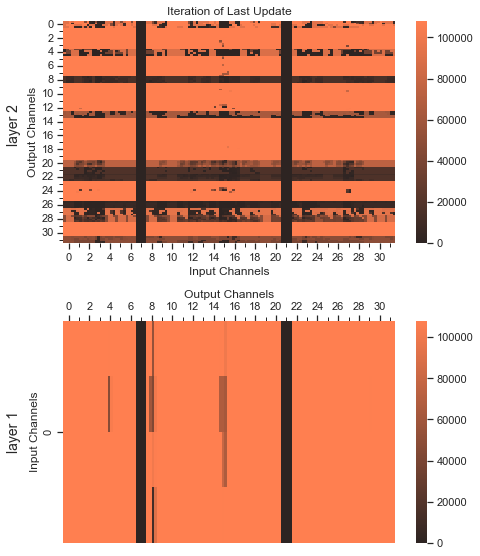

In [13]:
import numpy as np 

fig, axs = plt.subplots(ncols=1, nrows=2, figsize= [6.4*1, 4.8*2])
fig.subplots_adjust(
        left=0.0,
        hspace=0.35,
        wspace=0.3
    )

d = dndata[1][1].cpu().numpy()
ax = axs[0]
d = np.concatenate(d,axis=1)
d = np.concatenate(d,axis=1)

dnviz.heatmap_iteration(d, ax, True, title=titles[1])
ax.text(-19,60,"layer 2",horizontalalignment='center', verticalalignment='center', rotation=90, size=14)
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

d = dndata[0][1].cpu().numpy()
ax = axs[1]
d = np.concatenate(d,axis=1)
d = np.concatenate(d,axis=1)

dnviz.heatmap_iteration(d.transpose(), ax, True, transposed=True)
ax.text(-19,2,"layer 1",horizontalalignment='center', verticalalignment='center', rotation=90,  size=14)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

### 4.2.2. Deeper Layers have Higher Fractions of Dead Weights in Early Training

In the deeper layers of the encoder initially a big fraction of the network has dead neurons, but many can be recovered there, as the next to charts will show. This was also indicated in the plots above, depicted by the "Weights by Training Behaviour" plots, where weights in the category "started dead, revived" (REV) increase in relative height in the later layers of the encoder.

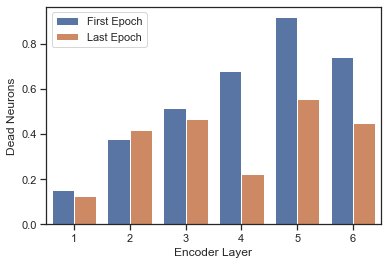

In [14]:
import pandas as pd

data = []
for i, weight in enumerate(dnviz.weights):
    t = (dndata[i][2][0]*1.0).numpy().mean()
    t2 = (dndata[i][2][-1]*1.0).numpy().mean()
    data.append([weight,t,t2])
    if i >=5:
        break

data = pd.DataFrame(data, columns=["weight","First Epoch", "Last Epoch"])
data = data.melt(id_vars=["weight"], value_vars=["First Epoch", "Last Epoch"])


ax = sns.barplot(data=data, x="weight", y='value', hue="variable")
ax.set_xticklabels(range(1,7))
ax.set_xlabel("Encoder Layer")
ax.set_ylabel("Dead Neurons")
ax.legend().set_title('')
plt.show()

The number of initially dead neurons increases with each subsequent layer up to layer 5. Only the last layer breaks that pattern. One potential explanation for this could be the smaller size of this layer. At the same time the last encoder layer is important for the network as it scales down the dimensionality to the latent encoding. A combination, which might force lower dead neuron rates.

Even though there are higher rates of initially dead neurons in later layers, also a substantial amount of dead neurons can recover there. Most of which revive after one more epoch as the next graphic shows (note the log scale). Generally, the amount of neurons that revive drops exponentially with each epoch.

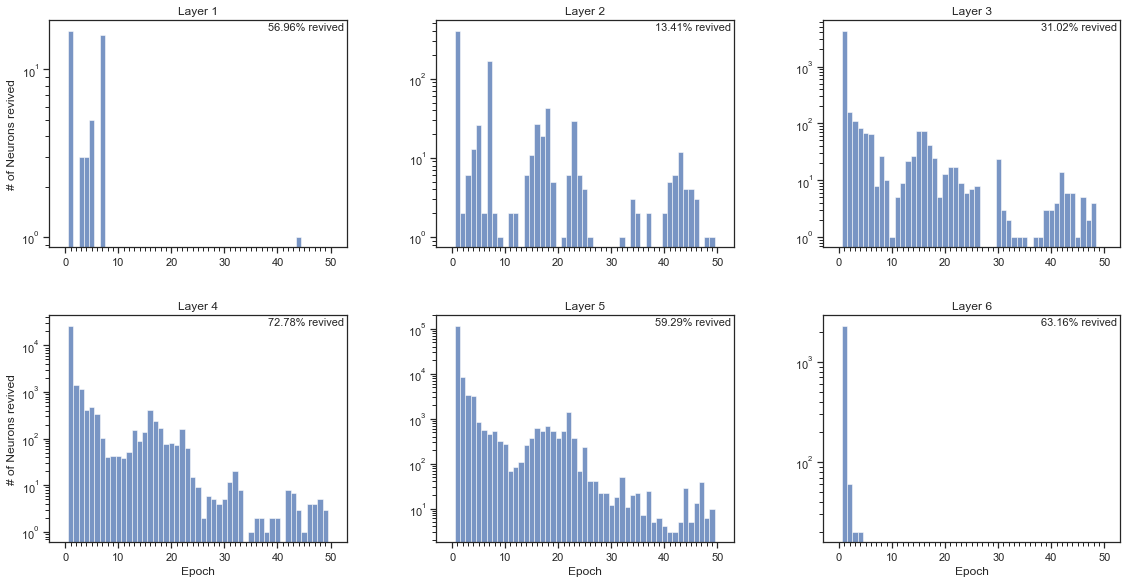

In [15]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize= [6.4*3, 4.8*2])
fig.subplots_adjust(
        hspace=0.3,
        wspace=0.3
    )
for i, weight in enumerate(dnviz.weights[:6]):
    tempdf = weightTypeDfs[i]
    tempdf = tempdf[tempdf["startedDead"] == True]
    df_revived = tempdf[tempdf["epochsUntilStateChange"] < 50]
    ax = sns.histplot(x=df_revived["epochsUntilStateChange"], ax=axs[i//3,i%3], binrange=[0,50], discrete=True)
    ax.text(.99,.99,"{:0.2f}% revived".format((len(df_revived)/len(tempdf))*100),size=11,horizontalalignment='right', verticalalignment='top',transform=ax.transAxes)
    ax.set_xticks(range(1,50), minor=True)
    ax.set_yscale('log')
    ax.set_title("Layer "+str(i+1))
    if i%3 == 0:
        ax.set_ylabel("# of Neurons revived")
    else:
        ax.set_ylabel("")

    if i//3 == 0:
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Epoch")
plt.show()

### 4.2.3. Most Weights are either Completely Dead or Alive the Whole Time

With the ReLU activation, one might expect that there is a subset of neurons that just gets updated irregularly, e.g. in 50% of cases there is an update and in the other 50% they don't activate so there is no update. However, as we can see in the "Weights by Number of Updates" charts, the vast majority of weights is in the far end of the y-axis, close to 0 updates or close to every iteration updated. I.e. most weights are either completely alive or completely dead during the training process. 

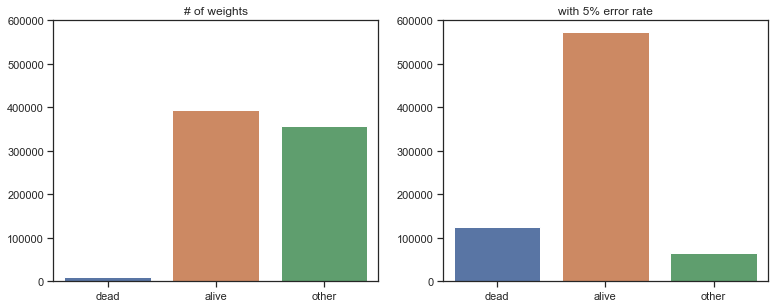

In [16]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize= [6.4*2, 4.8*1])
categories = ["dead", "alive", "other"]
error_rate = 0.05

alive, dead, total = 0,0,0
for i, weight in enumerate(dnviz.weights):
    update_count = dndata[i][0].flatten()
    alive += (update_count == dnviz.total_iterations).sum().item()
    dead += (update_count == 0).sum().item()
    total += len(update_count)
sns.barplot(x=categories, y=[dead, alive, total-dead-alive], ax=axs[0])
axs[0].set_title("# of weights")
axs[0].set_ylim([0, 6e5])

alive, dead, total = 0,0,0
for i, weight in enumerate(dnviz.weights):
    update_count = dndata[i][0].flatten()
    alive += (update_count > dnviz.total_iterations *(1-error_rate)).sum().item()
    dead += (update_count < dnviz.total_iterations*error_rate).sum().item()
    total += len(update_count)
sns.barplot(x=categories, y=[dead, alive, total-dead-alive], ax=axs[1])
axs[1].set_title("with 5% error rate")
axs[1].set_ylim([0, 6e5])

plt.show()

Note that the fraction of weights, that are stricly dead (update count == 0), is actually quite low, however, if we include an error rate, i.e. dead weights are defined by being updated only <= 5% of the time and alive weights are weights that updated >= 95% of the time, the picture changes drastically.

# 5. Annealed-BetaVAE vs (Vanilla) BetaVAE

Because most of the dead neurons are in the encoder part of the network, our hypothesis is that the restrictive KL penalty in the loss function combined with the ReLU activation function is a reason for so many neurons dying. Especially, as the Annealed BetaVAE objective is designed to have a particular high KL penalty during early training.

To test this, multiple regular BetaVAE models are trained to see the effect of different KL divergences on the training behaviour. (Although only on one random seed due to time constraints.) 

The loss function of the Annealed BetaVAE is designed to have a very restrictive KL penalty (in our case as if beta=100) in the beginning, but then allows for progressively higher KL divergence during the training period. While for (vanilla) BetaVAE on the other hand, the choice of beta usually will target a specific KL divergence for the whole training duration. (Higher beta values target lower KL divergencies.) The next chart will visualize that.

In [18]:
betas = [1,5,10]
df_betas = loadTensorboard("project_report_nb_data/runs_beta")
df = df.append(df_betas)

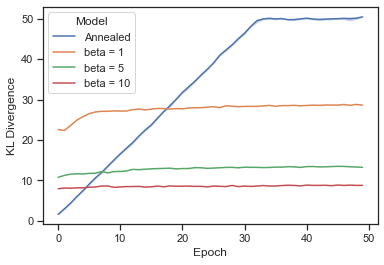

In [19]:
data = df

metrics = ["KL divergence/eval"]
data = data[data['metric'].isin(metrics)]
data = data[data['seed'] == '1506004']
ax = sns.lineplot(data=data, y='value', x="step", hue="model_name", hue_order=["gamma100.0","beta1","beta5", "beta10"])
ax.set_xlabel('Epoch')
ax.set_ylabel('KL Divergence')
ax.legend(title="Model", labels=["Annealed", "beta = 1","beta = 5","beta = 10"])
plt.show()

### 5.1. Comparison of Model Quality

When comparing the quality of what was learned, between Annealed BetaVAE and (vanilla) BetaVAE, we can see that vanilla BetaVAE can achieve better reconstruction, when using low beta values (allowing higher divergences). However, there the disentanglement quality suffers. (Which is why Annealed is in practice usually better, achieving good disentanglement with reasonable reconstruction.)

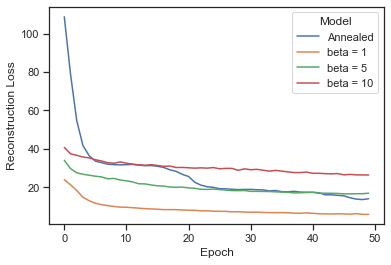

In [20]:
data = df

metrics = ["MSE reconstruction/eval"]
data = data[data['metric'].isin(metrics)]
data = data[data['seed'] == '1506004']
data = data[data['model_type'] == 'ReLU']
ax = sns.lineplot(data=data, y='value', x="step", hue="model_name", hue_order=["gamma100.0","beta1","beta5", "beta10"])
ax.set_xlabel('Epoch')
ax.set_ylabel('Reconstruction Loss')
ax.legend(title="Model", labels=["Annealed", "beta = 1","beta = 5","beta = 10"])
plt.show()

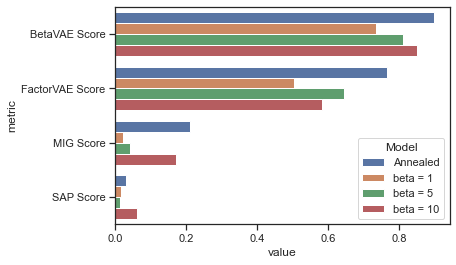

In [21]:
data = df[df['step'] ==49]
metrics = ["beta_vae_score/eval_accuracy", "factor_vae_score/eval_accuracy", "mig_score/discrete_mig", "sap_score/SAP_score"]
data = data[data['metric'].isin(metrics)]
data = data[data['seed'] == '1506004']
data = data[data['model_type'] == 'ReLU']
ax = sns.barplot(data=data, y='metric', x="value", hue="model_name", hue_order=["gamma100.0","beta1","beta5", "beta10"])
ax.set_yticklabels(['BetaVAE Score', 'FactorVAE Score', 'MIG Score', 'SAP Score'])
ax.get_legend().set_title("Model")
for t, l in zip(ax.get_legend().texts, ["Annealed", "beta = 1","beta = 5","beta = 10"]):
    t.set_text(l)
plt.show()

### 5.2. Dead Neuron Comparison
Do we see more or less dead neurons in BetaVAE? What is the effect of the beta hyperparameter on the amount of dead neurons (when using ReLU activation)?

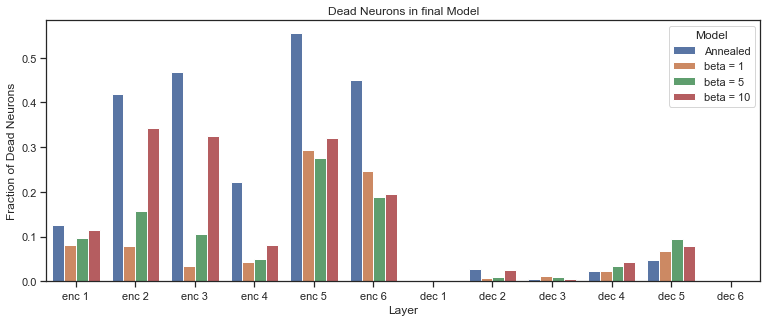

In [22]:
data = df[df['step'] ==49]
data = data[data['metric'].str.startswith("Dead_Neurons/")]
data = data[data['seed'] == '1506004']
data = data[data['model_type'] == 'ReLU']
fig, axs = plt.subplots(ncols=1, nrows=1, figsize= [6.4*2, 4.8*1])
ax = sns.barplot(data=data, y='value', x="metric", hue="model_name", hue_order=["gamma100.0","beta1","beta5", "beta10"])
ax.set_xticklabels(list(map(lambda x: 'enc '+str(x+1), range(6)))+list(map(lambda x: 'dec '+str(x+1), range(6))))
ax.set_xlabel('Layer')
ax.set_ylabel('Fraction of Dead Neurons')
ax.set_title('Dead Neurons in final Model')
ax.get_legend().set_title("Model")
for t, l in zip(ax.get_legend().texts, ["Annealed", "beta = 1","beta = 5","beta = 10"]):
    t.set_text(l)
plt.show()

As hypothesized, the BetaVAE models have substentially lower dead neuron rates than Annealed BetaVAE (in the encoder).

For the BetaVAE models, the convolutional layers (layers enc 1-4) show particularly a good pattern of dead neuron rates increasing with higher beta values (in accordance with the hypothesis). In the linear layer (enc 4 and 5), however, this patter breaks. Here the hyperparameter doesn't seem to have such a predictive effect (but still substentially lower than in Annealed BetaVAE).

In the decoder layers there are again only low levels of dead neurons.

Overall, it does seem like that a higher KL penalty increases dead neuron rates (when using ReLU activation).

# 6. Is the Network Architecture too big?

Since some layers have quite high dead neuron rates, but the quality of the model does not drop too much (when comparing ReLU with LeakyReLU), it might be that the neural network is configured with too many weights. To test this, the models are trained again, but with a reduced size for all 6 random seeds. The reductions were chosen to be roughly in accordance with the dead neuron rates in the respective layers. (Although, there are deviations, because of a simple implementation using integer deviations.)

The Network's encoder was adjusted the following way:
- layer 1: # of Filters (conv layer ouptupt channels) 32 -> 24
- layer 2: # of Filters (conv layer ouptupt channels) 32 -> 20
- layer 3: # of Filters (conv layer ouptupt channels) 64 -> 42
- layer 4: # of Filters (conv layer ouptupt channels) 64 -> 48
- layer 5: # of Features (linear layer output dimension) 256 -> 128

In [23]:
df_reduced = loadTensorboard("./project_report_nb_data/runs_reduced")
df["architectue"] = "normal"
df_reduced["architectue"] = "reduced"
df = df.append(df_reduced)

In [24]:
df['metric_wo_shape'] = df['metric'].map(lambda x: x[:x.index('[')] if x.startswith("Dead_Neurons/") else x)

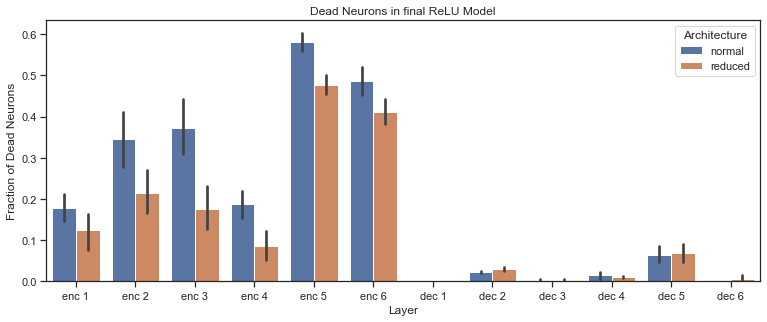

In [25]:
data = df[df['step'] ==49]
data = data[data['metric'].str.startswith("Dead_Neurons/")]
fig, axs = plt.subplots(ncols=1, nrows=1, figsize= [6.4*2, 4.8*1])
data = data[data['vae_model'] == 'AnnealedVAE']
data = data[data['model_type'] == 'ReLU']
ax = sns.barplot(data=data, y='value', x="metric_wo_shape", hue="architectue")
ax.set_xticklabels(list(map(lambda x: 'enc '+str(x+1), range(6)))+list(map(lambda x: 'dec '+str(x+1), range(6))))
ax.set_xlabel('Layer')
ax.set_ylabel('Fraction of Dead Neurons')
ax.set_title('Dead Neurons in final ReLU Model')
ax.legend(title="Architecture")
plt.show()

As we can see in the chart above, the reduced architecture has in fact a lower proportion of dead neurons, especially in the convolutional layers (first 4 layers). So it seems like a smaller network increases the pressure for neurons not to die when using ReLU, however, the dead neuron rates are still substantial so LeakyReLU remains a good recommendation as it yields no dead neurons at all.

The following chart shows the behaviour of the weights during training per layer. Across all layers, the reduced architecture started with a bigger fraction of neurons alive from the beginning ("never dead"). Additionally, the linear layers (layers 4 and 5) had a bigger fraction of neurons revive.

c:\Users\szapl\miniconda3\envs\carla_disentanglement\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


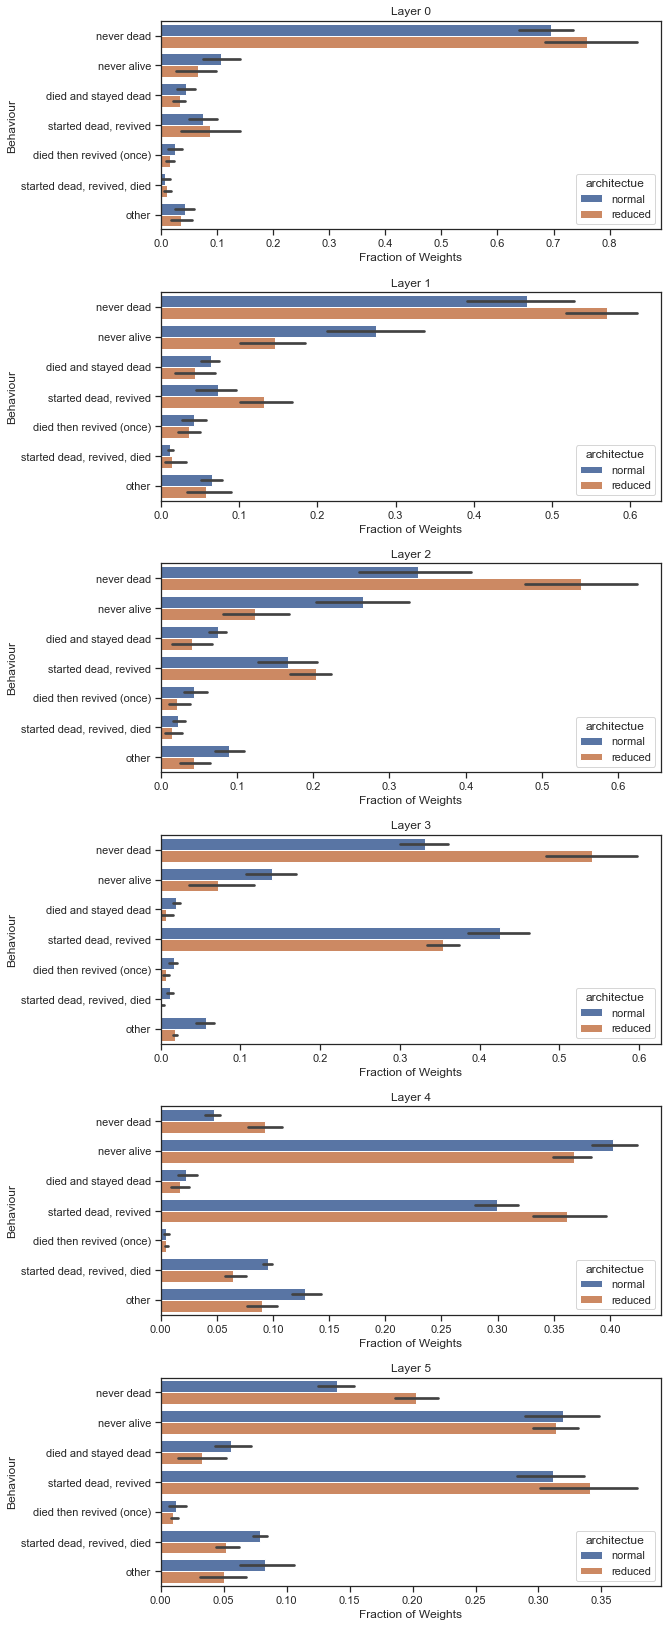

In [26]:
allDnData = []

seeds = ["1506004", "5863596", "9621873", "3972279", "7694365"]
for seed in seeds: 
    allDnData.append([
        dnviz.load('./project_report_nb_data/dndata', 's'+seed+'_ReLU'),
        dnviz.load('./project_report_nb_data/dndata', 'red.s'+seed+'_ReLU')
    ]) 
fig, axs = plt.subplots(ncols=1, nrows=6, figsize= [6.4*1.4, 4.8*6])
fig.subplots_adjust(
        hspace=0.3,
        wspace=0.3
    )
for i in range(6):
    datadf = pd.DataFrame()
    for j in range(len(seeds)):
        weightTypeDf = dnviz.getWeightTypeDistribution(allDnData[j][0][i])
        weightTypeDf_reduced = dnviz.getWeightTypeDistribution(allDnData[j][1][i])

        weightTypeDf = weightTypeDf.groupby("type_shorthand").size().reset_index(name='counts')
        weightTypeDf_reduced = weightTypeDf_reduced.groupby("type_shorthand").size().reset_index(name='counts')

        weightTypeDf["counts"] /= weightTypeDf.sum(0, numeric_only=True)["counts"]
        weightTypeDf_reduced["counts"] /= weightTypeDf_reduced.sum(0, numeric_only=True)["counts"]

        weightTypeDf["seed"] = seeds[j]
        weightTypeDf_reduced["seed"] = seeds[j]

        weightTypeDf["architectue"] = "normal"
        weightTypeDf_reduced["architectue"] = "reduced"

        datadf = datadf.append(weightTypeDf)
        datadf = datadf.append(weightTypeDf_reduced)

    handltext = ['ND', 'NA', 'DIED', 'REV', "REV1", "DRD", "OTH"]
    sns.barplot(data=datadf, y="type_shorthand", x="counts", ax=axs[i], order=handltext, hue="architectue")
    axs[i].set(title="Layer "+str(i), ylabel="Behaviour", xlabel="Fraction of Weights")
    axs[i].set_yticklabels(["never dead","never alive","died and stayed dead","started dead, revived","died then revived (once)","started dead, revived, died","other"])

fig.show()

#### 6.1 How does the Reduced Architecture Affect Performance?

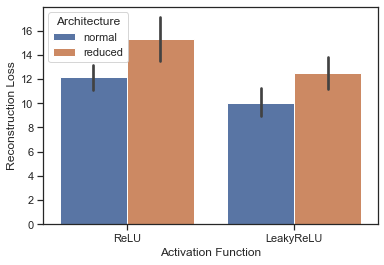

In [27]:
# data = df
data = df[df['step'] ==49]


metrics = ["MSE reconstruction/eval"]
data = data[data['metric'].isin(metrics)]
data = data[data['vae_model'] == 'AnnealedVAE']
ax = sns.barplot(data=data, y='value', x="model_type", hue="architectue")
ax.set_xlabel('Activation Function')
ax.set_ylabel('Reconstruction Loss')
ax.legend(title="Architecture")
plt.show()

We can see that the reduced architecture  leads to worse reconstruction (higher loss) in both loss functions, respectively. Additionally, also for the reduced architecture the finding that LeakyReLU improves reconstruction holds.

The following staticall tests show that these findings are statistically significant (for the chosen alpha value 0.05).

In [29]:
# ReLU: is the normal architecture better than the reduced one?
mannwhitneyu(
    data[(data['model_type'] == 'ReLU') & (data["architectue"] == "normal")]['value'].values, 
    data[(data['model_type'] == 'ReLU') & (data["architectue"] == "reduced")]['value'].values, 
    alternative='less')

MannwhitneyuResult(statistic=3.0, pvalue=0.010120285288538741)

In [30]:
# LeakyReLU: is the normal architecture better than the reduced one?
mannwhitneyu(
    data[(data['model_type'] == 'LeakyReLU') & (data["architectue"] == "normal")]['value'].values, 
    data[(data['model_type'] == 'LeakyReLU') & (data["architectue"] == "reduced")]['value'].values, 
    alternative='less')

MannwhitneyuResult(statistic=3.0, pvalue=0.010120285288538741)

In [28]:
# reduced Architecture: Is LeakyReLU better than ReLU?
mannwhitneyu(
    data[(data['model_type'] == 'LeakyReLU') & (data["architectue"] == "reduced")]['value'].values, 
    data[(data['model_type'] == 'ReLU') & (data["architectue"] == "reduced")]['value'].values, 
    alternative='less')

MannwhitneyuResult(statistic=4.0, pvalue=0.015319493968851633)

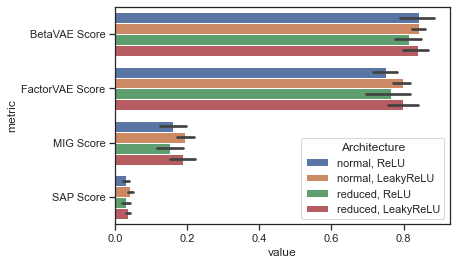

In [31]:
data = df[df['step'] ==49]
metrics = ["beta_vae_score/eval_accuracy", "factor_vae_score/eval_accuracy", "mig_score/discrete_mig", "sap_score/SAP_score"]
data = data[data['metric'].isin(metrics)]
data = data[data['vae_model'] == 'AnnealedVAE']
data["arch_act"] = data["architectue"] + ", " + data["model_type"]
ax = sns.barplot(data=data, y='metric', x="value", hue="arch_act")
ax.set_yticklabels(['BetaVAE Score', 'FactorVAE Score', 'MIG Score', 'SAP Score'])
ax.legend(title="Architecture")
plt.show()

For the disentanglement scores, again small differences are apparent. LeakyReLU is often slightly higher than ReLU, and the bigger architecture achieves higher scores than the reduced one. But nothing statistically significant.

In [32]:
metrics = ["beta_vae_score/eval_accuracy", "factor_vae_score/eval_accuracy", "mig_score/discrete_mig", "sap_score/SAP_score"]
print("  metric \t\t   p-value")
for metric in metrics:
    d = data[data['metric'] == metric]
    d = d[d["architectue"] == "reduced"]
    test = mannwhitneyu(d[d['model_type'] == 'LeakyReLU']['value'].values, d[d['model_type'] == 'ReLU']['value'].values, alternative='greater')
    print(metric.split('/')[0],"\t\t", test.pvalue)

  metric 		   p-value
beta_vae_score 		 0.11488313523056903
factor_vae_score 		 0.23558499924502785
mig_score 		 0.11488313523056903
sap_score 		 0.40341993337021864


# Conclusions

- ReLU creates high rates of dead neurons, when a restrictive loss is applied. (Sections 3 and 4)
    - Dead neuron rates scale with the restrictiveness. (Section 5)
- In smaller networks the effect is not as pronounced, but is still detrimental  to performance. (Section 6)
- Performance impact is mostly on reconstruction quality, disentanglement quality does not show statistical significance. (Section 1 and 2)
- Still, LeakyReLU or some other leaky activation is generally advisable.
    - With the exception, where slim networks are required, then it might be better to train on a big network with ReLU and prune dead cells.

The initial hypothesis, that the ReLU activation function causes dead neurons in Annealed BetaVAE models, was clearly shown in Sections 3 and 4. However, the hypothesis that it has a significant impact on performance, i.e. that it can make or break a useful model, was not confirmed in the experiments in this work. There is less reconstruction error when using LeakyReLU over ReLU, but not to the extent that a model might fail to learn completely (at least not with the chosen hyperparameters), which can happen in VAEs (especially with bad hyperparameters). In terms of disentanglement quality, there wasn't even a statistically significant difference in performance. Furthermore, it is reasonable to assume that the high levels of dead neurons play a major role in the differences in (reconstruction) performance, but there might be other causes not investigated here.

The further hypothesis, that the dead neurons are caused by restrictive loss term (KL Penalty) in combination with ReLU activation, was confirmed in Section 5. Vanilla BetaVAE has fewer dead neurons than Annealed BetaVAE, as the annealed objective has a very high penalty  in early training. Similarly, in vanilla BetaVAE, dead neuron rates increase with higher beta values.

Additionally, in section 6, we explored a reduced architecture. The results show that a limited architecture results in lower dead neuron rates - presumably as there is increased pressure to use the available weights - but also overall decrease performance.

The dead neuron effect (in regards to the activation function) is only happening in the encoder of the network. The small dead neuron rates there are presumably due to the upscaling (transposed convolution). The reason why there is no additional dead neuron effect due to ReLU is presumably because the KL penalty is not applied to this part of the network. It would be interesting to see if similar effects - of ReLU causing high levels of dead neurons in combination with (secondary) restrictive loss terms - do happen in other machine learning applications. Specifically, what kind of loss terms cause this effect, would be an interesting continuation of this research.

In practice, it might be advisable to use LeakyReLU - or one of the many similar activation functions like SELU or Swish - over ReLU to avoid dead neuron effects, like demonstrated here.
